# LIGN 167 Week 6: ASR

In [1]:
import librosa
from praatio import textgrid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from librikws import *
import os
from audio_utils import *
from tqdm import tqdm
import sklearn.manifold
tqdm.pandas()

## Load LibriSpeech data + alignments

In [2]:
df = get_sentence_df()
df = df.sample(10, random_state=42).reset_index(drop=True)
df.head()

,sentence_index,speaker,chapter,file,sentence
0,7578,250,140277,train-clean-100/250/140277/250-140277-0012.flac,and the problems surrounding symbols and cults...
1,14971,6848,252322,train-clean-100/6848/252322/6848-252322-0018.flac,that could n't compose you ten hexameters if y...
2,11490,1624,142933,train-clean-100/1624/142933/1624-142933-0008.flac,listen to that just listen to that song peter ...
3,9233,8425,246962,train-clean-100/8425/246962/8425-246962-0007.flac,that she had taken the evil part against the o...
4,20407,1355,39947,train-clean-100/1355/39947/1355-39947-0040.flac,that is coming to anyone who is the user of op...


In [3]:
mfcc = df['file'].progress_apply(lambda file: mfcc_w_deltas(get_librispeech_path(file)))
mfcc.shape

100%|██████████| 10/10 [00:00<00:00, 27.77it/s]


(10,)

In [4]:
textgrids = df['file'].progress_apply(get_librispeech_textgrid)
textgrids.shape

100%|██████████| 10/10 [00:00<00:00, 843.58it/s]


(10,)

In [5]:
textgrids.iloc[0]

,start,end,value,tier
0,0.12,0.28,and,words
1,0.28,0.35,the,words
2,0.35,0.88,problems,words
3,0.88,1.44,surrounding,words
4,1.44,2.04,symbols,words
...,...,...,...,...
155,11.64,11.70,IH0,phones
156,11.70,11.82,T,phones
157,11.82,11.97,IY0,phones
158,11.97,12.10,Z,phones


In [6]:
df['mfcc'] = mfcc
df['textgrid'] = textgrids
df.head()

,sentence_index,speaker,chapter,file,sentence,mfcc,textgrid
0,7578,250,140277,train-clean-100/250/140277/250-140277-0012.flac,and the problems surrounding symbols and cults...,"[[-527.3327, -493.9698, -496.79376, -520.46893...",start end value tier 0 0...
1,14971,6848,252322,train-clean-100/6848/252322/6848-252322-0018.flac,that could n't compose you ten hexameters if y...,"[[-495.42285, -479.1391, -467.61078, -460.6820...",start end value tier 0 0.19 ...
2,11490,1624,142933,train-clean-100/1624/142933/1624-142933-0008.flac,listen to that just listen to that song peter ...,"[[-518.74677, -482.35654, -451.22888, -430.347...",start end value tier 0 0.23 ...
3,9233,8425,246962,train-clean-100/8425/246962/8425-246962-0007.flac,that she had taken the evil part against the o...,"[[-481.34592, -464.53522, -461.19528, -460.323...",start end value tier 0 0.23 ...
4,20407,1355,39947,train-clean-100/1355/39947/1355-39947-0040.flac,that is coming to anyone who is the user of op...,"[[-459.01724, -444.44656, -469.1796, -495.5624...",start end value tier 0 0.08 ...


Now that we have a series of TextGrids and MFCCs for each audio, we need an array indexing each MFCC frame to its phone label.

In [7]:
def mfcc_to_phone_labels(mfcc: np.ndarray, textgrid: pd.DataFrame, tier_name='phones'):
    start = textgrid['start'].min()
    end = textgrid['end'].max()
    n_frames = mfcc.shape[1]
    frame_times = np.linspace(start, end, n_frames)
    phone_labels = []
    for t in frame_times:
        label = textgrid[
            (textgrid['start'] <= t) &\
            (textgrid['end'] >= t) &\
            (textgrid['tier'] == tier_name)
        ]['value']
        if not label.empty:
            phone_labels.append(label.values[0])
        else:
            phone_labels.append('SIL')
    assert len(phone_labels) == n_frames
    return phone_labels
df['phone_labels'] = df.progress_apply(
    lambda row: mfcc_to_phone_labels(
        row['mfcc'], row['textgrid']
    ), axis=1)
df.head()

100%|██████████| 10/10 [00:00<00:00, 14.45it/s]


,sentence_index,speaker,chapter,file,sentence,mfcc,textgrid,phone_labels
0,7578,250,140277,train-clean-100/250/140277/250-140277-0012.flac,and the problems surrounding symbols and cults...,"[[-527.3327, -493.9698, -496.79376, -520.46893...",start end value tier 0 0...,"[sil, sil, sil, sil, sil, sil, AE1, AE1, AE1, ..."
1,14971,6848,252322,train-clean-100/6848/252322/6848-252322-0018.flac,that could n't compose you ten hexameters if y...,"[[-495.42285, -479.1391, -467.61078, -460.6820...",start end value tier 0 0.19 ...,"[sil, sil, sil, sil, sil, sil, sil, sil, sil, ..."
2,11490,1624,142933,train-clean-100/1624/142933/1624-142933-0008.flac,listen to that just listen to that song peter ...,"[[-518.74677, -482.35654, -451.22888, -430.347...",start end value tier 0 0.23 ...,"[sil, sil, sil, sil, sil, sil, sil, sil, sil, ..."
3,9233,8425,246962,train-clean-100/8425/246962/8425-246962-0007.flac,that she had taken the evil part against the o...,"[[-481.34592, -464.53522, -461.19528, -460.323...",start end value tier 0 0.23 ...,"[sil, sil, sil, sil, sil, sil, sil, sil, sil, ..."
4,20407,1355,39947,train-clean-100/1355/39947/1355-39947-0040.flac,that is coming to anyone who is the user of op...,"[[-459.01724, -444.44656, -469.1796, -495.5624...",start end value tier 0 0.08 ...,"[sil, sil, sil, sil, DH, DH, DH, AH0, AH0, T, ..."


Now let's concatenate all MFCCs and phone labels to single arrays and perform t-SNE on the MFCCs.

In [8]:
mfcc_matrix = np.concat(mfcc.values, axis=1)
mfcc_matrix.shape

(39, 6310)

In [9]:
mfcc_pca = sklearn.decomposition.PCA(n_components=10, random_state=42)
mfcc_10d = mfcc_pca.fit_transform(mfcc_matrix.T)
mfcc_10d.shape

(6310, 10)

In [10]:
mfcc_tsne = sklearn.manifold.TSNE(n_components=2, random_state=42)
mfcc_2d = mfcc_tsne.fit_transform(mfcc_10d)
mfcc_2d.shape

(6310, 2)

In [11]:
phoneme_labels = []
for labels in df['phone_labels']:
    phoneme_labels.extend(labels)
phoneme_labels = np.array(phoneme_labels)
phoneme_labels.shape

(6310,)

In [12]:
phonemes_arpa = ['AH0', 'IY0', 'L', 'N']
phonemes_ipa = list('ailn')
arpa2ipa = {arpa:ipa for arpa, ipa in zip(phonemes_arpa, phonemes_ipa)}

labels_ipa = np.array([arpa2ipa.get(label, 'other') for label in phoneme_labels])
phoneme_mask = np.isin(labels_ipa, phonemes_ipa)

labels_ipa[phoneme_mask][:10]

array(['n', 'a', 'a', 'l', 'l', 'l', 'a', 'a', 'n', 'n'], dtype='<U5')

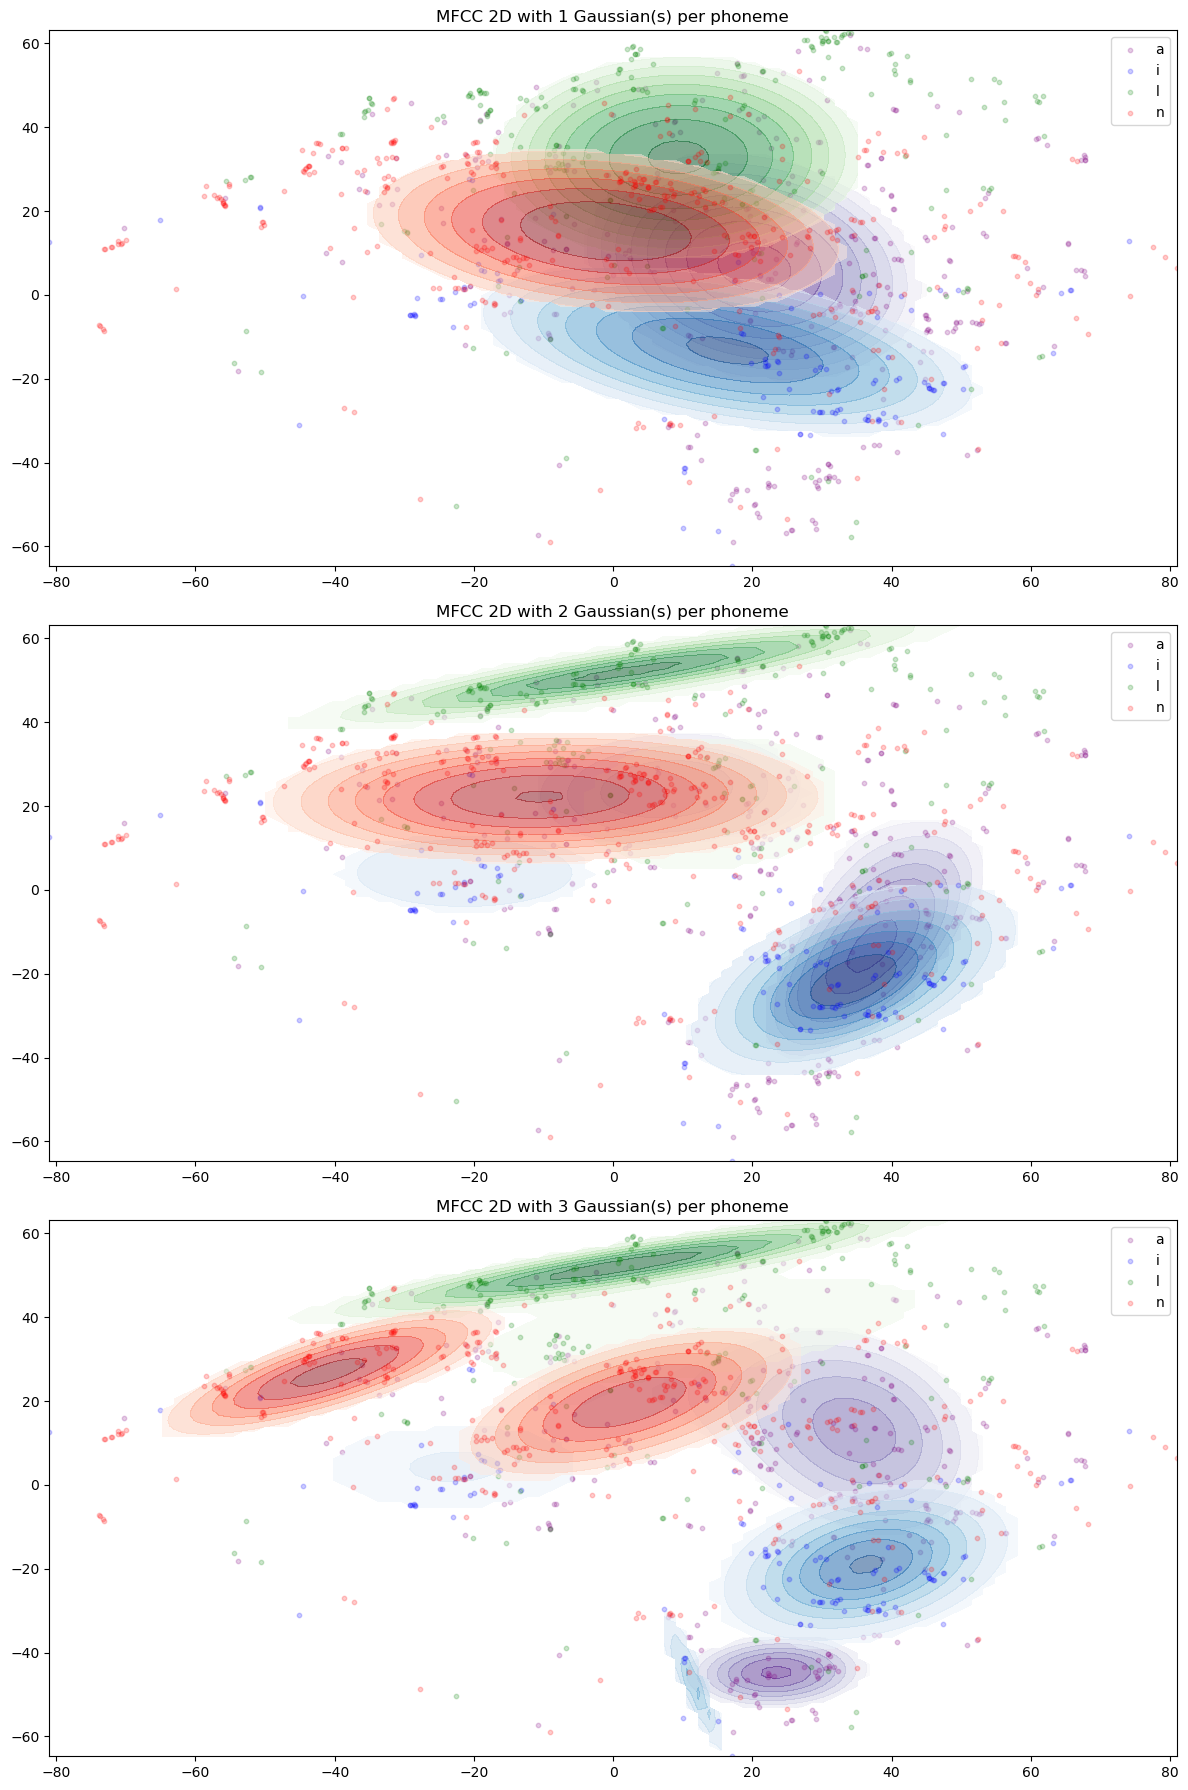

In [15]:
X_2d = mfcc_2d[phoneme_mask]
X_10d = mfcc_10d[phoneme_mask]
X = mfcc_matrix.T[phoneme_mask]
y_str = labels_ipa[phoneme_mask]
y = np.array([phonemes_ipa.index(label) for label in y_str], dtype=np.float32)

np.save('data/libris_mfcc_2d.npy', X_2d)
np.save('data/libris_phoneme_labels.npy', y)
np.save('data/libris_mfcc.npy', X)
np.save('data/libris_mfcc_10d.npy', X_10d)

states = fit_gaussians(X_2d, y, phones=phonemes_ipa, n_dist=1)
plot_mfcc_w_dists(
    mfcc_2d=X_2d,
    y=y,
    num_dist_seq=[1,2,3],
    phones=phonemes_ipa
)
plt.show()

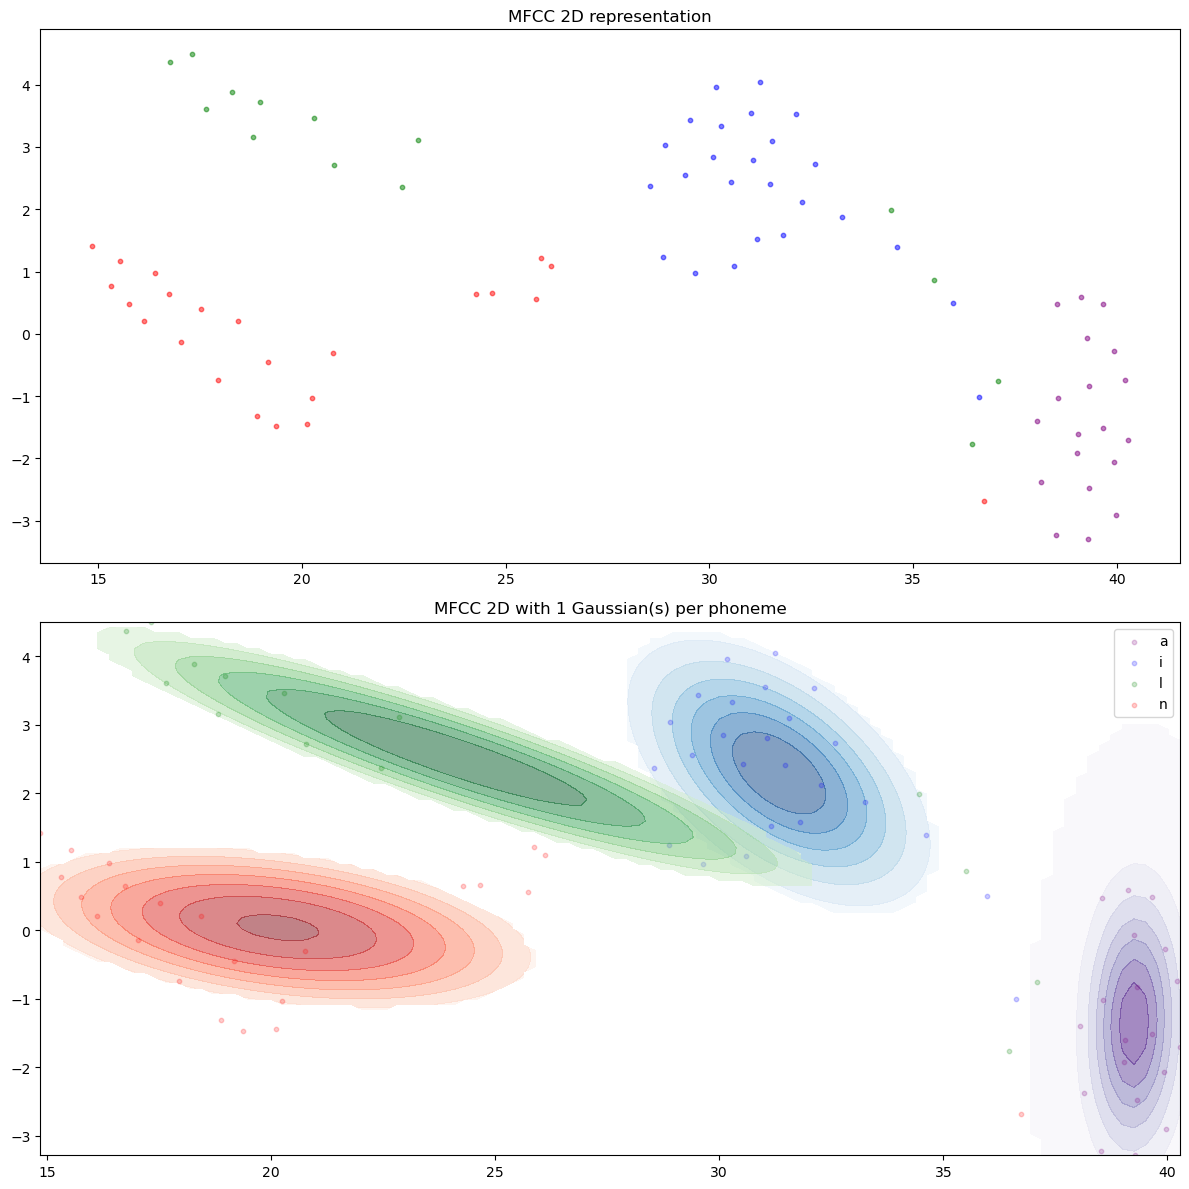

In [14]:
ailn_df = pd.read_csv('data/ailn_tsne.csv')
phone_mask = ailn_df['phone'].isin(list(phonemes_ipa))
ailn_df = ailn_df[phone_mask]
X_2d = ailn_df[['0', '1']].to_numpy()
y = ailn_df['phone'].apply(lambda p: phonemes_ipa.index(p)).to_numpy()
states = fit_gaussians(X_2d, y, phones=phonemes_ipa, n_dist=1)
plot_mfcc_w_dists(
    mfcc_2d=X_2d,
    y=y,
    num_dist_seq=[0, 1,],
    phones=phonemes_ipa
)
plt.show()